# Machine Learning Halo Finder

In [32]:
import pynbody as pb
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
s=pb.load('test_grafic++.02000')
s.physical_units()

# Full box

<IPython.core.display.Javascript object>


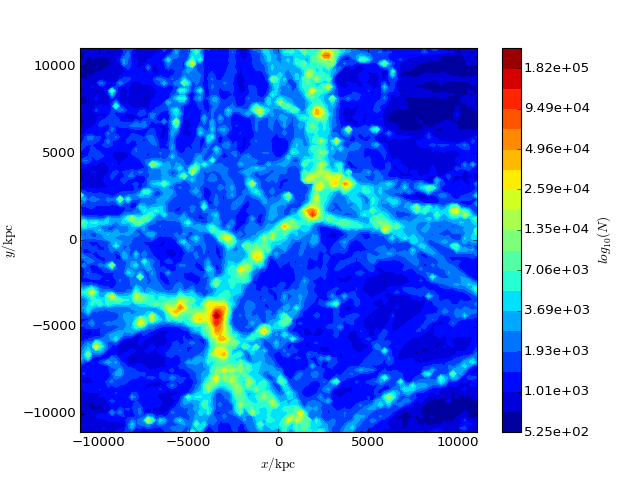

In [3]:
plt.figure()
hg = pb.plot.hist2d(s.d['y'], s.d['z'], colorbar=True)

In [4]:
d=2300
f=pb.filt.BandPass('x', str(-d)+' kpc', str(d)+' kpc')&pb.filt.BandPass('y', str(-d)+' kpc', str(d)+' kpc') & pb.filt.BandPass('z', str(-d)+' kpc', str(d)+' kpc')

# Sub sample to decrease particle numbers

<IPython.core.display.Javascript object>


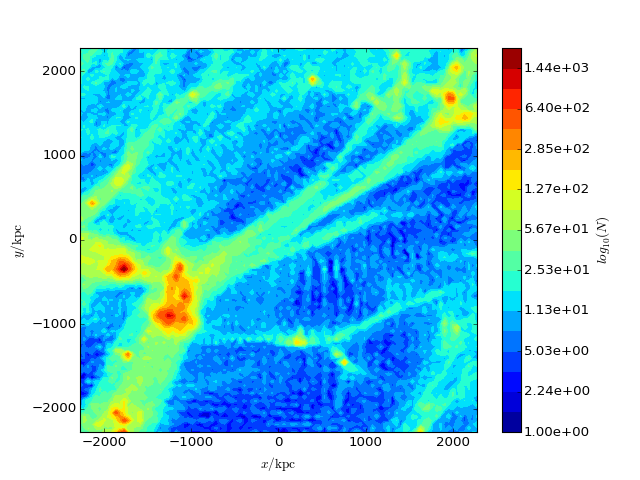

In [5]:
plt.figure()
h = pb.plot.hist2d(s[f].d['y'], s[f].d['z'], colorbar=True)

In [6]:
data=s.d[f]
subdata = np.array([data['x'],data['y'],data['z']])

In [60]:
train_class=np.empty([])
train_ind=np.empty([])

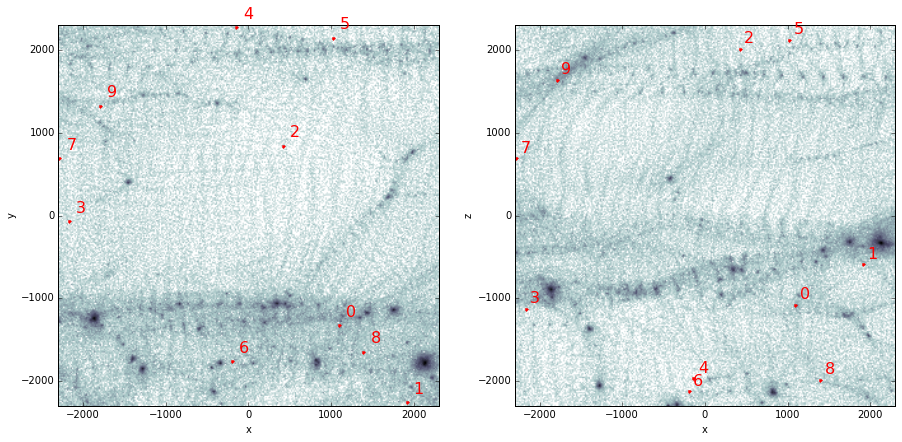

In [188]:
plt.close('all')
from matplotlib.widgets import Slider, Button, RadioButtons

fig=plt.figure(figsize=(15,15))
ax=fig.add_subplot(121)
ax2=fig.add_subplot(122)
H, b, e=np.histogram2d(subdata[0], subdata[1], bins=300)
G, b, e=np.histogram2d(subdata[0], subdata[2], bins=300)
#plt.subplots_adjust(wspace=0.5)
ax.imshow(np.log10(H.T+1), origin='lower', extent=(-d, d, -d, d), cmap='bone_r')
ax2.imshow(np.log10(G.T+1), origin='lower', extent=(-d, d, -d, d), cmap='bone_r')
ax.set_xlim(-d, d)
ax.set_ylim(-d, d)
ax2.set_xlim(-d, d)
ax2.set_ylim(-d, d)
ind=np.array(np.random.random(10)*len(subdata[0]), dtype='int')
ax.set_xlabel('x')
ax2.set_xlabel('x')
ax.set_ylabel('y')
ax2.set_ylabel('z')
for p in range(10):
    xp, yp, zp = subdata[0][ind], subdata[1][ind], subdata[2][ind]
    ax.plot(xp[p],yp[p],marker='.',color='r')
    ax.text(xp[p]+100,yp[p]+100,str(p),size=16,color='r')
    ax2.plot(xp[p],zp[p],marker='.',color='r')
    ax2.text(xp[p]+70,zp[p]+70,str(p),size=16,color='r')

In [186]:
temp=[]

In [187]:
if len(temp)==10:
    train_ind = np.append(train_ind, ind)
    train_class = np.append(train_class, temp)
else:
    print "NOOOO! You fu**ed it up!"
temp=[]

# Training set

Fractions of classifications (void = 0, filament = 1, halo = 2):

In [189]:
1.*np.bincount(np.array(train_class, dtype='int')) / len(train_class)

array([ 0.45,  0.38,  0.17])

In [201]:
train_class.shape

(100,)

# Spatial features

In [145]:
from sklearn.neighbors import NearestNeighbors
nbrs = NearestNeighbors(n_neighbors=50, algorithm='ball_tree').fit(subdata.T)
distances, indices = nbrs.kneighbors(subdata.T)

In [173]:
dist50=abs(subdata-subdata[:,indices.T[-1]])
diff50 = (dist50.max(axis=0)-dist50.min(axis=0))/distances[:,-1]
dist10=abs(subdata-subdata[:,indices.T[9]])
diff10 = (dist10.max(axis=0)-dist10.min(axis=0))/distances[:,9]
dist5=abs(subdata-subdata[:,indices.T[4]])
diff5 = (dist5.max(axis=0)-dist5.min(axis=0))/distances[:,4]

# Features

In [174]:
features=np.array([s[f].d['rho'], s[f].d['v_disp'], distances[:,9], diff5, diff10, diff50]).T

# GradientBoostingClassifier

In [190]:
train_ind = np.array(train_ind, dtype='int')

In [191]:
X_train = features[train_ind]
y_train = train_class

#print y_train
#print X_train

from sklearn.cross_validation import cross_val_score, ShuffleSplit
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.grid_search import GridSearchCV

grid = GridSearchCV(GradientBoostingClassifier(), 
                    {"n_estimators": [10, 50, 100],
                     "learning_rate": [0.0001, 0.001, 0.01, 0.1],
                     "max_leaf_nodes": [4, 8, 16]}, n_jobs=-1)
grid.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=3, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              random_state=None, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params={}, iid=True, loss_func=None, n_jobs=-1,
       param_grid={'n_estimators': [10, 50, 100], 'max_leaf_nodes': [4, 8, 16], 'learning_rate': [0.0001, 0.001, 0.01, 0.1]},
       pre_dispatch='2*n_jobs', refit=True, score_func=None, scoring=None,
       verbose=0)

# Optimized ML parameters

In [192]:
grid.best_estimator_

GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=3, max_features=None, max_leaf_nodes=8,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

[ 0.37982124  0.15256262  0.19523947  0.13668395  0.04965469  0.08270469]


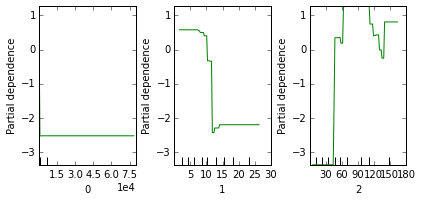

In [194]:
from sklearn.ensemble.partial_dependence import plot_partial_dependence

plot_partial_dependence(grid.best_estimator_, X_train, [0, 1, 2], label=0)
print grid.best_estimator_.feature_importances_

In [195]:
rf = grid.best_estimator_

rf_preds = rf.predict(features)
rf_predprob = rf.predict_proba(features)

Model 2

In [219]:
neighbor_class = np.array(rf_preds[indices[:,1:10]], dtype='int')
avg_neighbor=np.empty(len(neighbor_class), dtype='int')
for j, n in enumerate(neighbor_class):
    counts = np.bincount(n)
    avg_neighbor[j] = np.argmax(counts)

In [220]:
from sklearn.metrics import accuracy_score

accuracy_score(avg_neighbor, rf_preds)

0.80746781694412617

In [ ]:
model_two_preds = 

# Fractions of classifications by machine

In [196]:
print 1. * sum(rf_preds == 0)/len(rf_preds)
print 1. * sum(rf_preds == 1)/len(rf_preds)
print 1. * sum(rf_preds == 2)/len(rf_preds)

0.503700208937
0.386403360967
0.109896430096


# Classification Confidences

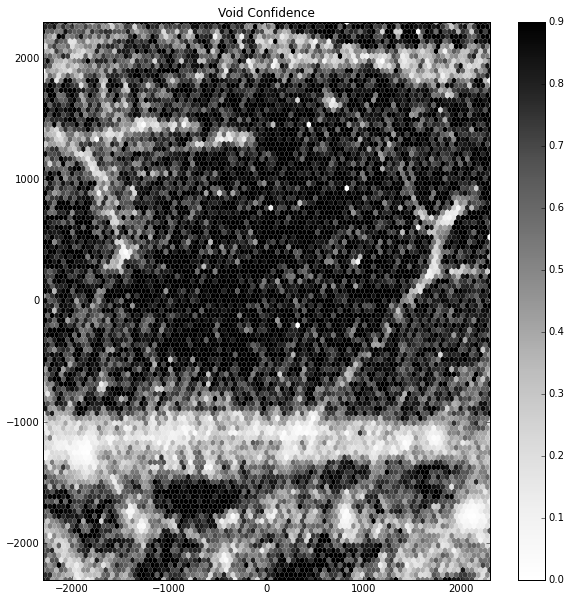

In [197]:
plt.figure(figsize=(10,10))
#v = pb.plot.hist2d(s[f].d['y'], s[f].d['z'])
v = 0
plt.hexbin(s[f].d['x'], s[f].d['y'], edgecolor="None", C=rf_predprob[:,v], reduce_C_function=np.mean, vmin=0, vmax=0.9)
plt.colorbar()
plt.set_cmap("Greys")
plt.title('Void Confidence')

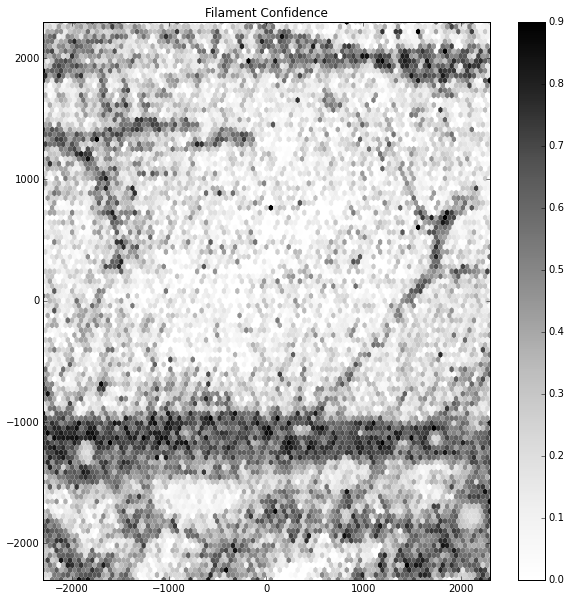

In [199]:
plt.figure(figsize=(10,10))
#v = pb.plot.hist2d(s[f].d['y'], s[f].d['z'])
v = 1
plt.hexbin(s[f].d['x'], s[f].d['y'], edgecolor="None", C=rf_predprob[:,v], reduce_C_function=np.mean, vmin=0, vmax=0.9)
plt.colorbar()
plt.set_cmap("Greys")
plt.title('Filament Confidence')

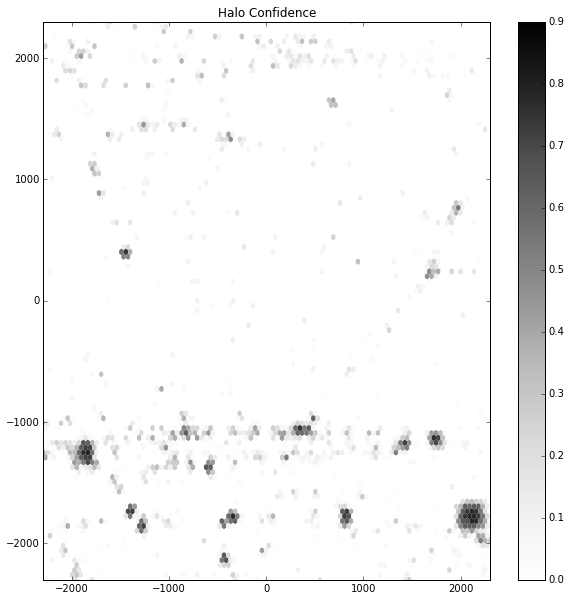

In [198]:
plt.figure(figsize=(10,10))
#v = pb.plot.hist2d(s[f].d['y'], s[f].d['z'])
v = 2
plt.hexbin(s[f].d['x'], s[f].d['y'], edgecolor="None", C=rf_predprob[:,v], reduce_C_function=np.mean, vmin=0, vmax=0.9)
plt.colorbar()
plt.set_cmap("Greys")
plt.title('Halo Confidence')

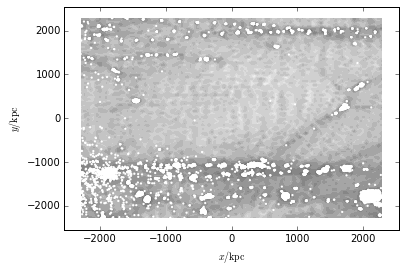

In [142]:
plt.figure()
v = pb.plot.hist2d(s[f].d['x'], s[f].d['y'])
v = 2
plt.scatter(s[f].d['x'][rf_preds == v], s[f].d['y'][rf_preds == v], edgecolor="None", c='w', marker='.')

In [24]:
overdensity = np.array(features[:,0]/np.mean(s[f]['rho']))

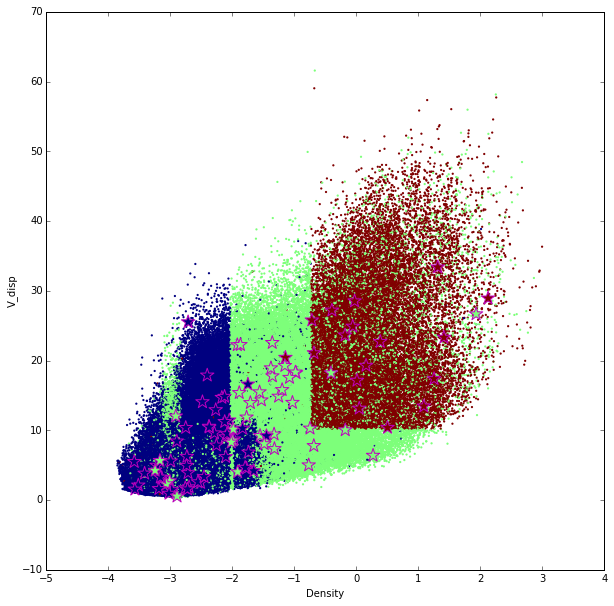

In [200]:
plt.figure(figsize=(10,10))
plt.xlabel('Density')
plt.ylabel('V_disp')
classes = ["Void","Filaments","Halo"]
plt.set_cmap('jet')
plt.scatter(np.log10(overdensity), features[:,1], marker='.', edgecolor='none', c=rf_preds)
plt.scatter(np.log10(overdensity[train_ind]), np.array(features[:,1])[train_ind], marker='*', edgecolor='m', c=train_class, s=200)

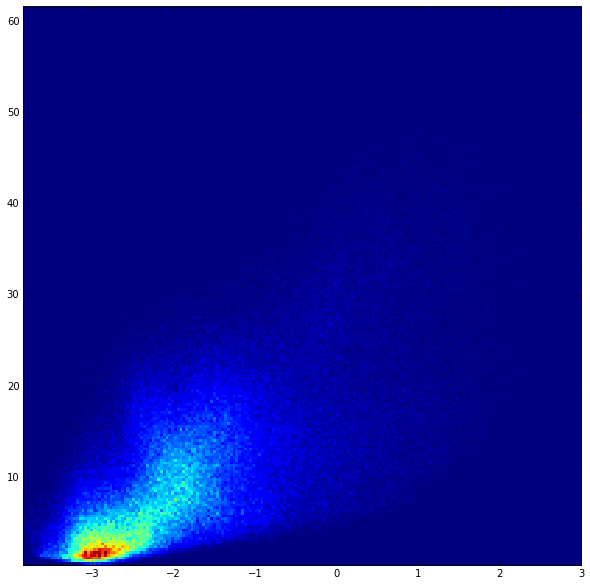

In [144]:
plt.figure(figsize=(10,10))
H = plt.hist2d(np.log10(overdensity), features[:,1], bins=200)

(array([ 1.,  2.,  0.,  1.,  0.,  0.,  0.,  0.,  2.,  1.]),
 array([ 0.31776971,  0.3854967 ,  0.45322369,  0.52095069,  0.58867768,
         0.65640467,  0.72413166,  0.79185865,  0.85958564,  0.92731264,
         0.99503963]),
 <a list of 10 Patch objects>)

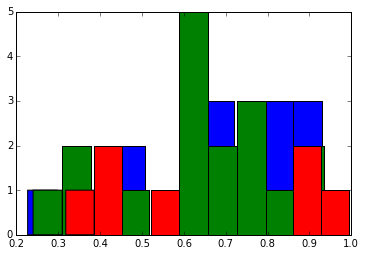

In [111]:
plt.hist(X_train[:,-3][train_class == 0])
plt.hist(X_train[:,-3][train_class == 1])
plt.hist(X_train[:,-3][train_class == 2])